In [1]:
%reset -f
import os
import gzip
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import preprocessing

In [2]:
def load_mnist(path, kind='train'):


    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
def _filter(xs, ys, lbls):
    idxs = [i for (i, l) in enumerate(ys) if l in lbls]
    return xs[idxs, :], ys[idxs]

In [4]:
def clear_gpu(model):
    # Removes model from gpu and clears the memory
    
    model = model.to('cpu')
    del model
    torch.cuda.empty_cache()

In [5]:
class Dataset(torch.utils.data.Dataset):
    # Basic dataset class to work with torch data loader

    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        assert len(X) == len(y), print("Number of examples don't match up")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [6]:
class LeNet(torch.nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.drop1 = torch.nn.Dropout(0.2)
        self.drop2 = torch.nn.Dropout(0.5)
        
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        
        self.fc1 = torch.nn.Linear(16 * 4 * 4, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 5)

    def forward(self, x):
        x = self.drop1(x)
        x = self.pool(F.relu(self.conv1(x)))

        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 16 * 4 * 4)
        x = self.drop2(x)

        x = F.relu(self.fc1(x))
        x = self.drop2(x)

        x = F.relu(self.fc2(x))
        x = self.drop2(x)

        x = self.fc3(x) 
  
        
        return x

In [7]:
def predict(X, y, model, loss_fn):
    
    model.eval()
    
    with torch.no_grad():
        out = model.forward(X)
        preds = out.argmax(axis=1)

        acc = sum(preds == y)/len(y)
        loss = loss_fn(out, y)
        
    model.train()
    
    return acc, loss

In [8]:
dataloader_params = {'batch_size': 32, 'shuffle': True, 'num_workers': 6}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load Data

In [9]:
train_images, train_labels = load_mnist('../data', 'train')
test_images, test_labels = load_mnist('../data', 't10k')

val_images = train_images[50000:]
val_labels = train_labels[50000:]

train_images = train_images[:50000]
train_labels = train_labels[:50000]

In [10]:
X_train1, y_train1 = _filter(train_images, train_labels, [0, 1, 4, 5, 8])
X_val1, y_val1 = _filter(val_images, val_labels, [0, 1, 4, 5, 8])
X_test1, y_test1 = _filter(test_images, test_labels, [0, 1, 4, 5, 8])

In [11]:
X_train2, y_train2 = _filter(train_images, train_labels, [2, 3, 6, 7, 9])
X_val2, y_val2 = _filter(val_images, val_labels, [2, 3, 6, 7, 9])
X_test2, y_test2 = _filter(test_images, test_labels, [2, 3, 6, 7, 9])

# FMNIST 2 Training

In [12]:
X_train2 = X_train2.reshape(X_train2.shape[0], 28, 28)
X_test2 = X_test2.reshape(X_test2.shape[0], 28, 28)
X_val2 = X_val2.reshape(X_val2.shape[0], 28, 28)

In [13]:
X_train2 = X_train2[:, np.newaxis, :, :]
X_test2 = X_test2[:, np.newaxis, :, :]
X_val2 = X_val2[:, np.newaxis, :, :]

In [14]:
le2 = preprocessing.LabelEncoder()
le2.fit(y_train2)
y_train2 = le2.transform(y_train2)
y_val2 = le2.transform(y_val2)
y_test2 = le2.transform(y_test2)

In [15]:
train_data2 = Dataset(X_train2, y_train2)
train_generator2 = torch.utils.data.DataLoader(train_data2, **dataloader_params)

X_train2 = torch.from_numpy(X_train2).type(torch.FloatTensor).to(device)
y_train2 = torch.Tensor(y_train2).type(torch.LongTensor).to(device)

X_val2 = torch.from_numpy(X_val2).type(torch.FloatTensor).to(device)
y_val2 = torch.Tensor(y_val2).type(torch.LongTensor).to(device)

X_test2 = torch.from_numpy(X_test2).type(torch.FloatTensor).to(device)
y_test2 = torch.Tensor(y_test2).type(torch.LongTensor).to(device)

In [16]:
net = LeNet().to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.7)

In [17]:
history = {
    'acc': [],
    'loss': [],
    'val_acc': [],
    'val_loss': []
}

for epoch in tqdm(range(100)):
    for i, data in enumerate(train_generator2):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor).to(device)
        labels =  labels.type(torch.LongTensor).to(device)

        optimizer.zero_grad()

        outputs = net.forward(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

    acc, loss = predict(X_val2, y_val2, net, loss_fn)
    history['val_acc'].append(acc)
    history['val_loss'].append(loss)
        
    acc, loss = predict(X_train2, y_train2, net, loss_fn)  
    history['acc'].append(acc)
    history['loss'].append(loss)

100%|██████████| 100/100 [05:36<00:00,  3.36s/it]


In [18]:
acc, loss = predict(X_test2, y_test2, net, loss_fn)
print(acc, loss)

tensor(0.9086, device='cuda:0') tensor(0.2440, device='cuda:0')


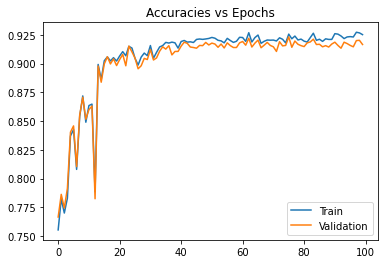

In [19]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title("Accuracies vs Epochs")
plt.legend(['Train', 'Validation'])
plt.show()

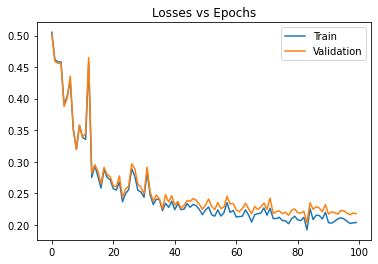

In [20]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Losses vs Epochs")
plt.legend(['Train', 'Validation'])
plt.show()